<a href="https://colab.research.google.com/github/RQYM/ADGAT/blob/main/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import os
import pandas as pd 
import re
from google.colab import drive
import numpy as np
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/TSdata/Subset of Funds/'
directories = {
   "CalmarRatio" : '/content/drive/MyDrive/TSdata/Subset of Funds/CalmarRatio_3Y.parquet',
   "Kappa"    : '/content/drive/MyDrive/TSdata/Subset of Funds/Kappa_3Y.parquet',
   "MaxDrawdown" : '/content/drive/MyDrive/TSdata/Subset of Funds/MaxDrawdown_3Y.parquet',
   "MRAR"    :  '/content/drive/MyDrive/TSdata/Subset of Funds/MRAR_3Y.parquet',
   "Return"   : '/content/drive/MyDrive/TSdata/Subset of Funds/Return_3Y.parquet',
   "Sharpe"   : '/content/drive/MyDrive/TSdata/Subset of Funds/Sharpe_3Y.parquet',
   "Sortino"   : '/content/drive/MyDrive/TSdata/Subset of Funds/Sortino_3Y.parquet',
   "Volatility" : '/content/drive/MyDrive/TSdata/Subset of Funds/Volatility_3Y.parquet' 
}

In [3]:
class BehavioralClustering:

    def __init__(self,directories):
        self.data = {}
        self.directories = directories

    def load_data(self, pm_list=None):
        if pm_list is None:
            pm_list = list(self.directories.keys())

        for i in pm_list:
            if i in self.directories.keys():
                print('loading '+ i)
                df = pd.read_parquet(self.directories[i])
                df.rename(self.__remove_zeros_from_column_names, axis = 1, inplace = True)
                self.data[i] = df
                
            else:
                raise ValueError("The Performance Measure", i, "directory has not been specified")

    def __remove_zeros_from_column_names(self,string):
        editted_str = re.sub(pattern = '(B)0*', repl = r'\1', string = string)
        return editted_str

    def gen_train_data(self,  date_ending = "2011-03-31",date_beginning = '2008-03-31'):
      """

      prepare training data and label
      return label, traning data
      """
      data_concat = None
      subset_mask_previous = None
      data = list(self.data.values())

      if (len(data) == 1):
          
          data = data[0]
          data_subset = data[(data.index >= pd.to_datetime(date_beginning)) & (data.index <= pd.to_datetime(date_ending))]
          subset_mask = ~data_subset.isin([np.nan, np.inf, -np.inf]).any()
          
          data_without_nan = data_subset.T[subset_mask]
          return data_subset.T[subset_mask].index , np.array(data_without_nan)[:,:,np.newaxis]

      else:
        for df in data:
            data_subset = df[(df.index >= pd.to_datetime(date_beginning)) & (df.index <= pd.to_datetime(date_ending)) ]
            subset_mask = ~data_subset.isin([np.nan, np.inf, -np.inf]).any()
            if subset_mask_previous is None:
                subset_mask_previous = np.array(subset_mask)
            else:
                subset_mask = np.array(subset_mask) & subset_mask_previous
                subset_mask_previous = subset_mask
        
        for df in data:
            data_subset = df[(df.index >= pd.to_datetime(date_beginning)) &(df.index <= pd.to_datetime(date_ending))]
            if data_concat is None:
                data_without_nan = np.array(data_subset.T[subset_mask])[:,:,np.newaxis]
                data_concat = data_without_nan
            else:
                data_concat = np.concatenate((data_concat, np.array(data_subset.T[subset_mask])[:,:,np.newaxis]), axis = 2)
            
        return data[0].T[subset_mask].index, data_concat

In [46]:
bh = BehavioralClustering(directories)
bh.load_data(["Return","Volatility"])
label ,train = bh.gen_train_data('2011-03-31', '2011-01-31' )
train = train.mean(axis = 1)
train.shape

loading Return
loading Volatility


(218, 2)

Text(0, 0.5, 'Volatility')

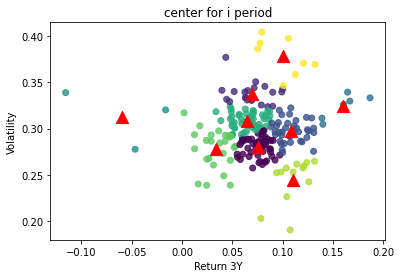

In [6]:
label ,train = bh.gen_train_data('2011-03-31', '2011-01-31' )
train = train.mean(axis = 1)
model = KMeans(9).fit(train)
c = model.cluster_centers_

plt.scatter(train[:,0],train[:,1], c = model.predict(train),alpha = 0.8 )
plt.scatter(c[:,0],c[:,1],color = 'r', s= 150,marker = '^')
plt.title('center for i period')
plt.xlabel('Return 3Y')
plt.ylabel('Volatility')

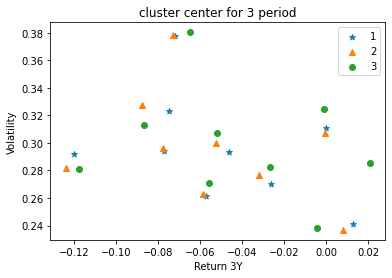

In [13]:
for i in range(3):
  label ,train = bh.gen_train_data(df.iloc[i]['cluster_date'] , df.iloc[i]['look_back'] )
  train = train.mean(axis = 1)
  model = KMeans(9).fit(train)
  c = model.cluster_centers_
  m = ['*','^','o','+','x']
  plt.scatter(c[:,0],c[:,1],marker = m[i],label = str(i+1))
plt.title('cluster center for 3 period')
plt.xlabel('Return 3Y')
plt.ylabel('Volatility') 
plt.legend() 

Hyperparamenter Tuning

In [53]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil = []
si2 = []
x_labe = []

label ,train = bh.gen_train_data('2011-03-31', '2011-01-31' )
train = train.mean(axis = 1)

for i in range(10,40):   
  clusterer = KMeans(n_clusters=i, random_state=10).fit(train)
  cluster_labels = clusterer.labels_
  silhouette_avg = silhouette_score(train, cluster_labels)
  sil.append(silhouette_avg)

  clusterer = GaussianMixture(i).fit(train)
  cluster_labels = clusterer.predict(train)
  silhouette_avg = silhouette_score(train, cluster_labels)
  si2.append(silhouette_avg)

  x_labe.append(str(i))

# plt.plot(x_labe,sil,label = 'Kmeans')
# plt.plot(x_labe,si2,label = 'GMM')
# plt.legend()

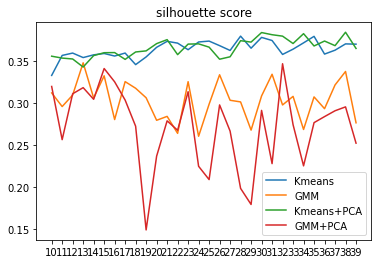

In [55]:
from sklearn.decomposition import PCA
label ,train = bh.gen_train_data('2011-03-31', '2011-01-31' )
# train = train.mean(axis = 1)

sil2 = []
si22 = []
x_labe = []
for i in range(train.shape[-1]):
  pca = PCA(n_components=1)
  x = pca.fit_transform(train[:,:,i])
  if i ==0 :
    trains = x
  else:
    trains = np.hstack((trains,x))

train = trains
for i in range(10,40):   
  clusterer = KMeans(n_clusters=i, random_state=10).fit(train)
  cluster_labels = clusterer.labels_
  silhouette_avg = silhouette_score(train, cluster_labels)
  sil2.append(silhouette_avg)

  clusterer = GaussianMixture(i).fit(train)
  cluster_labels = clusterer.predict(train)
  silhouette_avg = silhouette_score(train, cluster_labels)
  si22.append(silhouette_avg)

  x_labe.append(str(i))
plt.plot(x_labe,sil,label = 'Kmeans')
plt.plot(x_labe,si2,label = 'GMM')
plt.plot(x_labe,sil2,label = 'Kmeans+PCA')
plt.plot(x_labe,si22,label = 'GMM+PCA')
plt.title('silhouette score')
plt.legend()

Text(0, 0.5, 'Volatility')

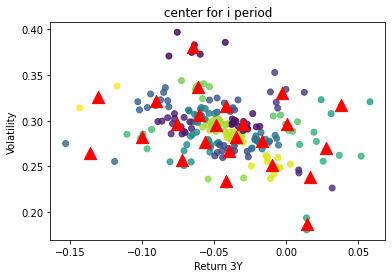

In [19]:
model = KMeans(24).fit(train)
c = model.cluster_centers_

plt.scatter(train[:,0],train[:,1], c = model.predict(train),alpha = 0.8 )
plt.scatter(c[:,0],c[:,1],color = 'r', s= 150,marker = '^')
plt.title('center for i period')
plt.xlabel('Return 3Y')
plt.ylabel('Volatility')

In [24]:
def tuning(train):
  sil = []
  x_labe = []
  for i in range(10,30):   
      clusterer = KMeans(n_clusters=i, random_state=10).fit(train)
      cluster_labels = clusterer.labels_
      silhouette_avg = silhouette_score(train, cluster_labels)
      sil.append(silhouette_avg)
      x_labe.append(i)
  return x_labe[sil.index(max(sil))]

No handles with labels found to put in legend.


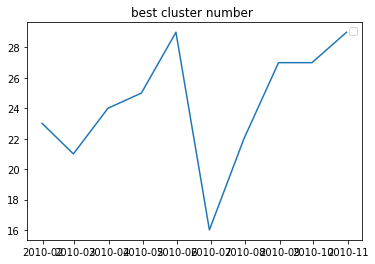

In [27]:
d = []
num = []
for i in range(10):
  label ,train = bh.gen_train_data(df.iloc[i]['cluster_date'] , df.iloc[i]['look_back'] )
  train = train.mean(axis = 1)
  num.append(tuning(train))
  d.append( pd.Timestamp( df.iloc[i]['cluster_date']))
plt.title('best cluster number ')
plt.plot(d,num)
plt.legend() 

In [8]:
returns = pd.read_parquet('/content/drive/MyDrive/TSdata/Time Series/ClusterGroup_Return_3Y.parquet')
def remove_zeros_from_column_names(string):
    editted_str = re.sub(pattern = '(B)0*', repl = r'\1', string = string)
    return editted_str
returns.rename(remove_zeros_from_column_names, axis = 1, inplace = True)
# start = '2010-01-31'
# end = '2020-01-31'

def gen_month_date(returns,start,end,look_back_date):
  dates = returns.index
  dates = dates[dates >= pd.Timestamp(start)  ]
  dates = dates[dates < pd.Timestamp(end)  ]
  dates = pd.DataFrame(dates)
  dates['month'] = dates['Date'].apply(lambda x: x.strftime('%Y-%m'))
  start = dates.groupby('month').apply(lambda x: x.iloc[-1])
  index_start = dates.groupby('month').apply(lambda x: x.iloc[0]).iloc[1:]
  index_end = start.iloc[1:]
  cluster_date = start.iloc[:-1]
  look_back = cluster_date['Date'] - pd.Timedelta(look_back_date,unit ='d')
  index_start = list(index_start['Date'])
  index_end = index_start.copy()
  index_end.append(pd.Timestamp(end))
  df = pd.DataFrame(
      {
        'look_back' : list(look_back.values),
        'cluster_date' : list(cluster_date['Date']),
        'index_start' : index_start,
        'index_end' : index_end[1:]  
      }
  )
  return df

In [9]:
df = gen_month_date(returns,'2010-01-31','2010-12-31',30*3)


In [ ]:
import sklearn.metrics as metrics
! pip install tslearn
from tslearn.clustering import TimeSeriesKMeans
import sklearn.cluster as sklearn_cluster

     |████████████████████████████████| 793 kB 17.2 MB/s 


In [ ]:
def k_means_clustering(train,label,cluster):

    model = TimeSeriesKMeans(cluster, verbose = True, random_state = 1)
    cluster_k_means = model.fit_predict(train)
    k_means_model = pd.DataFrame({"Funds": label, "Cluster": cluster_k_means})

    eval_data = train.reshape(train.shape[0], train.shape[1]*train.shape[2])

    # silh_score = metrics.silhouette_score(eval_data, k_means_model.Cluster)
    # ch_score = metrics.calinski_harabasz_score(eval_data, k_means_model.Cluster)
    # db_score = metrics.davies_bouldin_score(eval_data, k_means_model.Cluster)
    # s_dbw_score = S_Dbw(np.array(eval_data), k_means_model.Cluster) (silh_score, ch_score, db_score),

    return  k_means_model

In [ ]:
price = pd.read_parquet('/content/drive/MyDrive/TSdata/Subset of Funds/DailyPrice.parquet')
price.rename(remove_zeros_from_column_names, axis = 1, inplace = True)
size = pd.read_parquet('/content/drive/MyDrive/TSdata/Subset of Funds/FundSize.parquet')
size.rename(remove_zeros_from_column_names, axis = 1, inplace = True)


In [ ]:
def cluter_avg(dates,price,clu):
  price_month = price.loc[dates['index_start']:dates['index_end']]
  price_month = price_month/price_month.iloc[0]
  p = price_month.T
  p.index.name = 'Funds'
  p.columns = range(1,p.shape[1]+1)
  p = p.reset_index()
  clu1 = pd.merge(clu,p ,on ='Funds',how = 'left')
  del clu1['Funds']
  clu1 = clu1.groupby('Cluster').mean()
  clu1 = clu1.reset_index()
  clu1['Date'] = dates['index_start']
  clu1 = clu1.set_index(['Date','Cluster'])
  return clu1

In [ ]:
def cluter_weight(dates,size,price,clu):
  s = price.loc[dates['index_start']].to_frame('size')
  clu2 = pd.merge(clu,s ,on ='Funds',how = 'left')
  price_month = price.loc[dates['index_start']:dates['index_end']]
  price_month = price_month/price_month.iloc[0]
  p = price_month.T
  p.index.name = 'Funds'
  p.columns = range(1,p.shape[1]+1)
  p = p.reset_index()
  clu1 = pd.merge(clu,p ,on ='Funds',how = 'left')
  del clu1['Funds']
  clu1 = clu1.set_index('Cluster')
  clu1 = (clu1.T*np.array(clu2['size'])).T.reset_index()

  clu1 = clu1.groupby('Cluster').mean()
  cz = clu2.groupby('Cluster')['size'].mean()
  clu1 = (clu1.T / np.array(cz)).T
  clu1 = clu1.reset_index()
  clu1['Date'] = dates['index_start']
  clu1 = clu1.set_index(['Date','Cluster'])
  return clu1

In [ ]:
cluter = pd.DataFrame()
avg_index = pd.DataFrame()
weight_index = pd.DataFrame()
for i in range(10):
  # print(dates['cluster_date'])
  dates = df.iloc[i]
  label ,train = bh.gen_train_data(dates['cluster_date'] , dates['look_back'] )

  clu = k_means_clustering(train,label,20)
  avg = cluter_avg(dates,price,clu)
  wei = cluter_weight(dates,size,price,clu)

  clu['Cluster_date'] = dates['cluster_date']
  cluter = pd.concat([cluter,clu])
  avg_index = pd.concat([avg_index,avg])
  weight_index = pd.concat([weight_index,wei])

0.314 --> 0.242 --> 0.233 --> 0.227 --> 0.224 --> 0.223 --> 0.223 --> 0.223 --> 0.223 --> 
0.314 --> 0.237 --> 0.228 --> 0.224 --> 0.223 --> 0.223 --> 0.223 --> 
0.287 --> 0.225 --> 0.216 --> 0.213 --> 0.213 --> 0.212 --> 0.211 --> 0.211 --> 0.211 --> 
0.304 --> 0.215 --> 0.206 --> 0.203 --> 0.203 --> 0.203 --> 0.203 --> 
0.279 --> 0.204 --> 0.196 --> 0.192 --> 0.190 --> 0.189 --> 0.189 --> 0.189 --> 
0.256 --> 0.193 --> 0.190 --> 0.190 --> 0.189 --> 0.189 --> 0.189 --> 
0.243 --> 0.179 --> 0.174 --> 0.172 --> 0.172 --> 0.172 --> 0.171 --> 0.171 --> 0.171 --> 0.171 --> 0.171 --> 
0.256 --> 0.190 --> 0.179 --> 0.175 --> 0.173 --> 0.171 --> 0.171 --> 0.171 --> 0.171 --> 0.171 --> 
0.248 --> 0.181 --> 0.176 --> 0.174 --> 0.174 --> 0.173 --> 0.173 --> 
0.240 --> 0.178 --> 0.174 --> 0.173 --> 0.173 --> 0.173 --> 


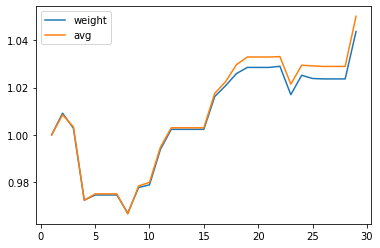

In [ ]:
import matplotlib.pyplot as plt
weight_index.loc[pd.Timestamp('2010-02-01'),0].T.plot(label = 'weight')
avg_index.loc[pd.Timestamp('2010-02-01'),0].T.plot(label = 'avg')
plt.legend()

In [ ]:
avg_index

1         2         3         4         5         6   \
Date       Cluster                                                          
2010-02-01 0        1.0  1.008465  1.003410  0.972311  0.975034  0.975034   
           1        1.0  1.008798  1.002093  0.970461  0.973602  0.973602   
           2        1.0  1.011076  1.007458  0.972417  0.974407  0.974407   
           3        1.0  1.010374  1.004663  0.974302  0.977075  0.977075   
           4        1.0  1.009588  1.004633  0.970485  0.974313  0.974313   
...                 ...       ...       ...       ...       ...       ...   
2010-11-01 15       1.0  1.015459  1.017751  1.038563  1.042252  1.042252   
           16       1.0  1.015617  1.019166  1.044176  1.048889  1.048889   
           17       1.0  1.015530  1.017984  1.039474  1.043994  1.043994   
           18       1.0  1.015375  1.015500  1.035987  1.038962  1.038962   
           19       1.0  1.014922  1.018008  1.038348  1.042696  1.042696   

                          7         8         9         10  ...        23  \
Date       Cluster                                          ...             
2010-02-01 0        0.975034  0.966558  0.978409  0.979922  ...  1.021459   
           1        0.973602  0.963786  0.976733  0.978356  ...  1.021503   
           2        0.974407  0.967658  0.981589  0.983270  ...  1.016886   
           3        0.977075  0.968533  0.982102  0.983043  ...  1.020099   
           4        0.974313  0.965711  0.979949  0.981393  ...  1.022897   
...                      ...       ...       ...       ...  ...       ...   
2010-11-01 15       1.042252  1.041492  1.030860  1.041433  ...  1.025134   
           16       1.048889  1.050015  1.038629  1.047619  ...  1.027810   
           17       1.043994  1.043890  1.034930  1.045741  ...  1.027708   
           18       1.038962  1.038754  1.031049  1.039800  ...  1.021028   
           19       1.042696  1.043867  1.033277  1.043883  ...  1.031963   

                          24        25        26        27        28  \
Date       Cluster                                                     
2010-02-01 0        1.029466  1.029182  1.028958  1.028958  1.028958   
           1        1.030594  1.030680  1.028116  1.028116  1.028116   
           2        1.024644  1.025216  1.026791  1.026791  1.026791   
           3        1.027003  1.028863  1.026905  1.026905  1.026905   
           4        1.031442  1.031647  1.029760  1.029760  1.029760   
...                      ...       ...       ...       ...       ...   
2010-11-01 15       1.046847  1.046847  1.041759  1.041759  1.041759   
           16       1.048141  1.048141  1.041442  1.041442  1.041442   
           17       1.049825  1.049825  1.044648  1.044648  1.044648   
           18       1.039324  1.039324  1.034589  1.034589  1.034589   
           19       1.054368  1.054368  1.049774  1.049774  1.049774   

                          29        30        31  32  
Date       Cluster                                    
2010-02-01 0        1.050187       NaN       NaN NaN  
           1        1.047979       NaN       NaN NaN  
           2        1.049653       NaN       NaN NaN  
           3        1.045409       NaN       NaN NaN  
           4        1.051544       NaN       NaN NaN  
...                      ...       ...       ...  ..  
2010-11-01 15       1.039511  1.035011  1.057039 NaN  
           16       1.041076  1.035898  1.058532 NaN  
           17       1.042387  1.036309  1.060462 NaN  
           18       1.033454  1.028345  1.048497 NaN  
           19       1.047023  1.042995  1.066351 NaN  

[200 rows x 32 columns]

In [ ]:
def hierarchical_clustering(train,label,cluster, linkage = 'ward'):
    #cluster is some number
    #careful: data_dict must be in the same form as when you input data as dictionary for subset function above

    combined_data = train.reshape(train.shape[0], train.shape[1]*train.shape[2]) 
    model = sklearn_cluster.AgglomerativeClustering(cluster, linkage = linkage)
    cluster_hierarchies = model.fit_predict( combined_data)
    hierarchical_model = pd.DataFrame({"Funds": label, "Cluster": cluster_hierarchies})

    silh_score = metrics.silhouette_score(combined_data, hierarchical_model.Cluster)
    ch_score = metrics.calinski_harabasz_score(combined_data, hierarchical_model.Cluster)
    db_score = metrics.davies_bouldin_score(combined_data, hierarchical_model.Cluster)
    # s_dbw_score = S_Dbw(np.array(combined_data), hierarchical_model.Cluster)

    return (silh_score, ch_score, db_score) , hierarchical_model

In [ ]:
# main function
def k_means_clustering(train,label,cluster):

    model = TimeSeriesKMeans(cluster, verbose = True, random_state = 1)
    cluster_k_means = model.fit_predict(train)
    k_means_model = pd.DataFrame({"Funds": label, "Cluster": cluster_k_means})

    eval_data = train.reshape(train.shape[0], train.shape[1]*train.shape[2])

    silh_score = metrics.silhouette_score(eval_data, k_means_model.Cluster)
    ch_score = metrics.calinski_harabasz_score(eval_data, k_means_model.Cluster)
    db_score = metrics.davies_bouldin_score(eval_data, k_means_model.Cluster)
    # s_dbw_score = S_Dbw(np.array(eval_data), k_means_model.Cluster)

    return (silh_score, ch_score, db_score), k_means_model

In [ ]:
# a,b = hierarchical_clustering(train,label,30, linkage = 'ward')
# b.groupby('Cluster').size()
df = k_means_clustering(train,label,30)

89.804 --> 73.284 --> 71.944 --> 71.297 --> 70.953 --> 70.732 --> 70.632 --> 70.528 --> 70.415 --> 70.337 --> 70.209 --> 70.046 --> 69.807 --> 69.695 --> 69.611 --> 69.565 --> 69.521 --> 69.449 --> 69.309 --> 69.168 --> 69.049 --> 69.000 --> 68.981 --> 68.970 --> 68.960 --> 68.955 --> 68.953 --> 68.953 --> 68.952 --> 68.950 --> 68.949 --> 68.944 --> 68.940 --> 68.935 --> 68.922 --> 68.900 --> 68.882 --> 68.869 --> 68.855 --> 68.845 --> 68.836 --> 68.824 --> 68.814 --> 68.809 --> 68.804 --> 68.800 --> 68.796 --> 68.793 --> 68.790 --> 68.789 --> 


In [ ]:
class ATE:
    def __init__(self,label,train,n_filters=50, kernel_size=10, strides=1, n_units=[50, 1]):

      self.label = label
      self.train = train
      self.input_dim = train.shape[-1]
      self.timesteps = train.shape[1]
      self.n_filters =  n_filters
      self.kernel_size = kernel_size
      self.strides = strides
      self.n_units = n_units
                                                    
                                                                          
    def initialize(self):
      if self.isPrime(self.train.shape[1]):
        print('Number of funds specified is prime. The default pool size is the number of funds.')
        #X_train = X_train[:, :X_train.shape[1]-1, :] The previous group decided to drop the 'last' fund.
        self.pool_size =self.train.shape[1]
      elif self.train.shape[1] <= 10:
          self.pool_size = self.train.shape[1]
      else:
          for i in range(2, self.train.shape[1]//2):
                  if self.train.shape[1] % i == 0:
                      self.pool_size = i

      self.autoencoder, self.encoder, self.decoder = self.temporal_autoencoder(input_dim=self.input_dim,
                                        timesteps = self.timesteps,
                                        n_filters = self.n_filters,
                                        kernel_size = self.kernel_size,
                                        strides = self.strides,
                                        pool_size = self.pool_size,
                                        n_units = self.n_units) 
    def isPrime(self,n):
      if n > 1:
          if n == 2:
              return True
          if n % 2 == 0:
              return False
          for x in range(3, int(math.sqrt(n) + 1), 2):
              if n % x == 0:
                  return False
          return True
      return False


    def temporal_autoencoder(self,input_dim, timesteps, n_filters, kernel_size, strides, pool_size, n_units):
        """
        Temporal Autoencoder (TAE) model with Convolutional and BiLSTM layers.
        # Arguments
            input_dim: input dimension
            timesteps: number of timesteps (can be None for variable length sequences)
            n_filters: number of filters in convolutional layer
            kernel_size: size of kernel in convolutional layer
            strides: strides in convolutional layer
            pool_size: pooling size in max pooling layer, must divide time series length
            n_units: numbers of units in the two BiLSTM layers
            alpha: coefficient in Student's kernel
            dist_metric: distance metric between latent sequences
        # Return
            (ae_model, encoder_model, decoder_model): AE, encoder and decoder models
        """
        assert(timesteps % pool_size == 0)

        # Input
        x = Input(shape=(timesteps, input_dim), name='input_seq')

        # Encoder
        encoded = Conv1D(n_filters, kernel_size, strides=strides, padding='same', activation='linear')(x)
        encoded = LeakyReLU()(encoded)
        encoded = MaxPool1D(pool_size)(encoded)
        encoded = Bidirectional(CuDNNLSTM(n_units[0], return_sequences=True), merge_mode='sum')(encoded)
        encoded = LeakyReLU()(encoded)
        encoded = Bidirectional(CuDNNLSTM(n_units[1], return_sequences=True), merge_mode='sum')(encoded)
        encoded = LeakyReLU(name='latent')(encoded)

        # Decoder
        decoded = Reshape((-1, 1, n_units[1]), name='reshape')(encoded)
        decoded = UpSampling2D((pool_size, 1), name='upsampling')(decoded)  #decoded = UpSampling1D(pool_size, name='upsampling')(decoded)
        decoded = Conv2DTranspose(input_dim, (kernel_size, 1), padding='same', name='conv2dtranspose')(decoded)
        output = Reshape((-1, input_dim), name='output_seq')(decoded)  #output = Conv1D(1, kernel_size, strides=strides, padding='same', activation='linear', name='output_seq')(decoded)

        # AE model
        autoencoder = Model(inputs=x, outputs=output, name='AE')

        # Encoder model
        encoder = Model(inputs=x, outputs=encoded, name='encoder')

        # Create input for decoder model
        encoded_input = Input(shape=(timesteps // pool_size, n_units[1]), name='decoder_input')

        # Internal layers in decoder
        decoded = autoencoder.get_layer('reshape')(encoded_input)
        decoded = autoencoder.get_layer('upsampling')(decoded)
        decoded = autoencoder.get_layer('conv2dtranspose')(decoded)
        decoder_output = autoencoder.get_layer('output_seq')(decoded)

        # Decoder model
        decoder = Model(inputs=encoded_input, outputs=decoder_output, name='decoder')

        return autoencoder, encoder, decoder



In [ ]:
def DTC_auto_fit( label ,X_train ,
                 n_clusters = 10, n_filters = 50, kernel_size = 10, strides = 1,
                 n_units=[50, 1], alpha = 1.0, dist_metric='eucl', cluster_init='kmeans',
                 gamma = 1, optimizer = 'adam', learning_rate = 0.0001,
                 ae_weights = None,
                 pretrain_optimizer = 'adam', pretrain_epochs = 10, batch_size = 64, tol = 0.001, patience = 5, 
                 save_dir = None,
                 dtc_epochs = 100):

    # X_train = X_train.T
    #Determine the pool size:
    if isPrime(X_train.shape[1]):
        print('Number of funds specified is prime. The default pool size is the number of funds.')
        #X_train = X_train[:, :X_train.shape[1]-1, :] The previous group decided to drop the 'last' fund.
        pool_size = X_train.shape[1]
    elif X_train.shape[1] <= 10:
        pool_size = X_train.shape[1]
    else:
        for i in range(2, X_train.shape[1]//2):
                if X_train.shape[1] % i == 0:
                    pool_size = i
    
    if save_dir is not None:
      if not os.path.exists(save_dir):
          os.makedirs(save_dir)

    #Instantiate the model
    dtc = DTC(n_clusters = n_clusters,
              input_dim = X_train.shape[-1],
              timesteps = X_train.shape[1],
              n_filters = n_filters,
              kernel_size = kernel_size,
              strides = strides,
              pool_size = pool_size,
              n_units = n_units,
              alpha = alpha,
              dist_metric = dist_metric,
              cluster_init = cluster_init)
    
    #Initialize the model
    dtc.initialize()
    print(dtc.model.summary())
    
    if optimizer == 'adam':
        import tensorflow as tf
        from tensorflow import keras
        opt = keras.optimizers.Adam(learning_rate = learning_rate)
        dtc.compile(gamma = gamma, optimizer = opt)
    else:
        dtc.compile(gamma = gamma, optimizer = optimizer)

    # Load pre-trained AE weights or pre-train
    if ae_weights is None and pretrain_epochs > 0:
        dtc.pretrain(X = X_train, optimizer = pretrain_optimizer,
                     epochs = pretrain_epochs, batch_size = batch_size,
                     save_dir = save_dir)
    # elif args.ae_weights is not None:
    #     dtc.load_ae_weights(args.ae_weights)

    # Initialize clusters
    dtc.init_cluster_weights(X_train)
    
    # Fit model
    t0 = time()
    dtc.fit(X_train = X_train, 
            epochs = dtc_epochs, 
            eval_epochs = dtc_epochs//10, 
            save_epochs = dtc_epochs//10, 
            batch_size = batch_size, 
            tol = tol, 
            patience = patience, 
            save_dir = save_dir)
    
    
    q = dtc.model.predict(X_train)
    clustering_output = pd.DataFrame({"Funds": label, "Cluster": q[1].argmax(axis = 1)})
    return clustering_output